<a href="https://colab.research.google.com/github/gabriel-picussa/MVP-de-SSD---Gabriel-Picussa/blob/main/C%C3%B3pia_de_READ_ME_PREVISAO_DE_SALARIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MVP — Predição de Salários (v3)



**Objetivo**: estimar salário anual a partir de atributos demográficos e profissionais (idade, gênero, escolaridade, cargo e anos de experiência).
Tipo de problema: **Regressão supervisionada**
 já que o alvo (Salary) é uma variável numérica contínua.
 **1) Carregamento → 2) Preparação → 3) EDA → 4) Treino → 5) Avaliação → 6) Previsão interativa**. Para resolver esse problema, 4 diferentes tipos de regressão foram testados, cada um com suas características:

**1**. **Regressão** **Linear**

Conceito: É o modelo mais simples de regressão. Assume que existe uma relação linear entre as variáveis de entrada (idade, escolaridade, experiência, etc.) e o salário.

Objetivo no projeto: Servir como baseline (referência inicial) para comparar com modelos mais complexos. Apesar de simples, pode capturar relações diretas (ex.: mais anos de experiência → salário mais alto).

**2. Random Forest Regressor**

Conceito: É um modelo baseado em múltiplas árvores de decisão. Cada árvore aprende de maneira diferente (com amostras variadas e subconjuntos de variáveis) e o resultado final é a média das previsões de todas elas.

Objetivo no projeto: Capturar relações não lineares entre as variáveis e o salário, além de reduzir o risco de overfitting, já que o conjunto de árvores é mais estável que uma árvore isolada.

**3. Gradient Boosting Regressor**

Conceito: Também é baseado em árvores, mas funciona de forma sequencial. Cada nova árvore é treinada para corrigir os erros das árvores anteriores, melhorando a performance gradualmente.

Objetivo no projeto: Alcançar maior precisão do que a Random Forest, ao custo de maior tempo de processamento. É especialmente útil quando queremos maximizar a acurácia das previsões.

**4. Gradient Boosting Regressor (GridSearch)**
A mesma técnica de Gradient Boosting, mas com busca em grade (GridSearchCV) para encontrar melhores hiperparâmetros (número de árvores, taxa de aprendizado, profundidade, etc.).

O motivo de testar múltiplos modelos é comparar abordagens diferentes (simples vs complexas) e ver qual tem melhor equilíbrio entre erro baixo e capacidade de generalização.

**Hipóteses**:

**Mais anos de experiência e maior escolaridade → salários mais altos.**

Diferenças por cargo influenciam fortemente o salário.



Observação de moeda: pelos valores (ex.: 45k–180k) e faixas de mercado, tratamos salário como USD/ano; se desejar, o caderno pode converter para BRL para contexto local.
Restrições/decisões: dados tabulares simples, sem PII, abordagem com modelos clássicos, comparação justa via mesmo pipeline.



Atende aos pedidos:
- **Carregamento automático do GitHub** (sem upload/sem botões).
- **Unificação de Education Level** (*Bachelor's, Master's, PhD*).
- **Gráficos com números** (correlação anotada) e **tendência** em *Age × Years_of_Experience*.
- **Treino automático** (sem botões) com correção do erro de `squared` → **RMSE = sqrt(MSE)** (compatível com versões antigas do scikit-learn).
- **UI de previsão** com `ipywidgets` que **atualiza automaticamente** ao mover os controles (sem clicar).
- **(Opcional)** Matriz de confusão **automática** (target discretizado por quantis, apenas didática).


## 1) Configurações & Imports




In [ ]:

# Link do GitHub (raw). Altere aqui se necessário.
GITHUB_URL = "https://raw.githubusercontent.com/gabriel-picussa/MVP-de-SSD---Gabriel-Picussa/main/Salary_DatA.xlsx"

# Pacotes
try:
    import ipywidgets as widgets
except Exception:
    !pip -q install ipywidgets
    import ipywidgets as widgets

import pandas as pd, numpy as np, matplotlib.pyplot as plt, requests, io, re
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix

plt.rcParams['figure.figsize'] = (8,5)
pd.options.mode.copy_on_write = True  # pandas >=2.0

def to_raw_github_url(url: str) -> str:
    if "github.com" in url and "/blob/" in url:
        parts = url.split("github.com/")[-1]
        user_repo, rest = parts.split("/blob/", 1)
        return f"https://raw.githubusercontent.com/{user_repo}/{rest}"
    return url


## 2) Carregar dados automaticamente do GitHub

In [ ]:

RAW = to_raw_github_url(GITHUB_URL)
print("Lendo:", RAW)
resp = requests.get(RAW, timeout=30)
resp.raise_for_status()
df = pd.read_excel(io.BytesIO(resp.content))
print("Dimensões:", df.shape)
display(df.head())


Lendo: https://raw.githubusercontent.com/gabriel-picussa/MVP-de-SSD---Gabriel-Picussa/main/Salary_DatA.xlsx
Dimensões: (1787, 6)


,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32,Male,Bachelor's,Account Manager,5.0,75000
1,31,Female,Bachelor's,Accountant,4.0,55000
2,39,Female,Bachelor's,Administrative Assistant,10.0,55000
3,36,Female,Bachelor's,Administrative Assistant,8.0,45000
4,49,Male,Bachelor's Degree,Back end Developer,24.0,178284


## 3) Preparação & Harmonização (auto)
Harmonização de escolaridade (foi padronizado as repetições de nomes apenas por erro de escrita,porém são a mesma coisa).

“Bachelor’s” ≡ “Bachelor’s Degree” → Bachelor's

“Master’s” ≡ “Master’s Degree” → Master's

“phD/PhD” → PhD
(normalização robusta a caixa/acentos/apóstrofos).

In [ ]:

def prep_df(df):
    df = df.copy()
    df.columns = [str(c).strip().replace(' ', '_').replace('-', '_') for c in df.columns]
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    categorical_cols = [c for c in df.columns if c not in numeric_cols]
    # Fill básicos
    df[numeric_cols] = df[numeric_cols].apply(lambda s: s.fillna(s.median()))
    for c in categorical_cols:
        df[c] = df[c].astype(str).fillna('Missing').replace({'nan':'Missing'})
    # Unificação de Education Level
    col = 'Education_Level' if 'Education_Level' in df.columns else ('education_level' if 'education_level' in df.columns else None)
    def normalize_edu(v: str) -> str:
        t = str(v).strip()
        low = t.lower().replace("degree","").replace(".","").replace(" ", "").replace("'", "")
        if "bachelor" in low: return "Bachelor's"
        if "master"  in low: return "Master's"
        if "phd" in low or "doutor" in low: return "PhD"
        return t
    if col: df[col] = df[col].apply(normalize_edu)
    return df

df = prep_df(df)
print("Colunas:", list(df.columns))
for c in ['Education_Level','education_level']:
    if c in df.columns:
        print(c, "→", sorted(df[c].unique().tolist()))
display(df.head())


Colunas: ['Age', 'Gender', 'Education_Level', 'Job_Title', 'Years_of_Experience', 'Salary']
Education_Level → ["Bachelor's", 'High School', "Master's", 'PhD']


,Age,Gender,Education_Level,Job_Title,Years_of_Experience,Salary
0,32,Male,Bachelor's,Account Manager,5.0,75000
1,31,Female,Bachelor's,Accountant,4.0,55000
2,39,Female,Bachelor's,Administrative Assistant,10.0,55000
3,36,Female,Bachelor's,Administrative Assistant,8.0,45000
4,49,Male,Bachelor's,Back end Developer,24.0,178284


## 4) Seleção automática de Target e Features

Esse passo faz a escolha automática do alvo (Target) e das variáveis explicativas (Features) do seu modelo. A função guess_target percorre os nomes das colunas e, por meio de expressões regulares, procura aquela que parece representar salário (salary, remun, pay, wage) e, se encontrar pistas como usd, annual ou year, prioriza essa coluna como TARGET. Em seguida, define FEATURES como todas as demais colunas diferentes do alvo (ex.: idade, gênero, escolaridade, cargo, anos de experiência). **O objetivo é automatizar a preparação do problema de regressão — evitando erros manuais, deixando o notebook plug-and-play e preparando o terreno para a EDA, o train_test_split e o treinamento dos modelos.**

In [ ]:

def guess_target(cols):
    cands = [c for c in cols if re.search(r"salary|remun|pay|wage", str(c), re.I)]
    for c in cands:
        if re.search(r"usd|annual|year", str(c), re.I): return c
    return cands[0] if cands else cols[0]

TARGET = guess_target(list(df.columns))
FEATURES = [c for c in df.columns if c != TARGET]

print("TARGET =", TARGET)
print("FEATURES =", FEATURES)


TARGET = Salary
FEATURES = ['Age', 'Gender', 'Education_Level', 'Job_Title', 'Years_of_Experience']


## 5) EDA automática (com números e tendência)
Esse passo não treina modelo ainda — ele faz a Análise Exploratória de Dados (EDA).
O objetivo é explorar e visualizar os dados já existentes, para identificar padrões, outliers e relações entre variáveis que podem influenciar no salário.

- Os gráficos mostram que a distribuição dos salários é ampla sendo a maioria dos salários (50% do total) fica entre aproximadamente 70 mil e 160 mil, mas com alguns valores bastante altos que aparecem como outliers superiores ou inferiroes.
- O boxplot reforça essa dispersão, evidenciando uma mediana próxima de 110 mil e uma cauda longa de salários elevados.
- Quando observamos no recorte por escolaridade vemos um crescimento consistente de salário com o nível educacional, onde doutores (PhD) ganham significativamente mais do que mestres, bacharéis e pessoas com apenas ensino médio.
- A matriz de correlação e os gráficos de dispersão confirmam relações esperadas: idade e anos de experiência estão fortemente correlacionados entre si (0.94) e ambos se relacionam positivamente com o salário (0.77 e 0.82).
- O gráfico de Idade × Experiência mostra uma clara tendência linear, e o de Experiência × Salário demonstra que quanto mais anos de experiência, maior tende a ser a remuneração, apesar da dispersão indicar que outros fatores (como cargo ou setor) também influenciam bastante.
- Em conjunto, a análise exploratória valida que variáveis como escolaridade, experiência e idade são bons candidatos para explicar a variação nos salários, justificando o uso da regressão no próximo passo.

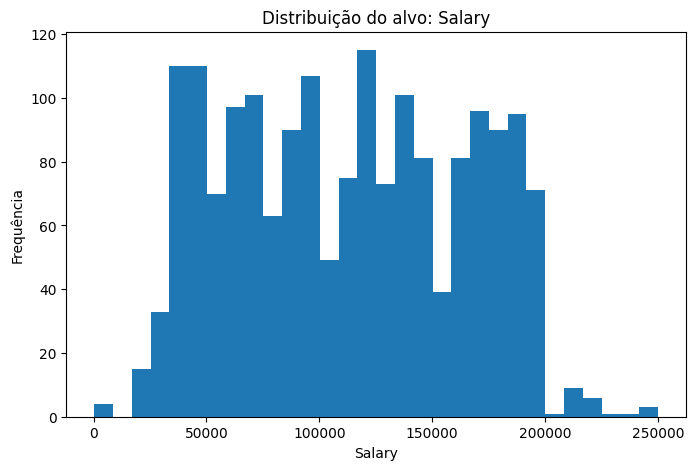

/tmp/ipython-input-432734614.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); plt.boxplot(df[TARGET].dropna(), labels=[TARGET]); plt.title(f"Boxplot do alvo: {TARGET}"); plt.show()


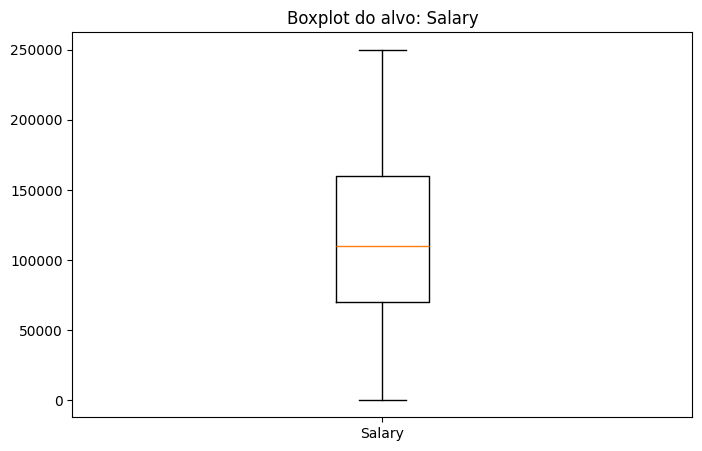

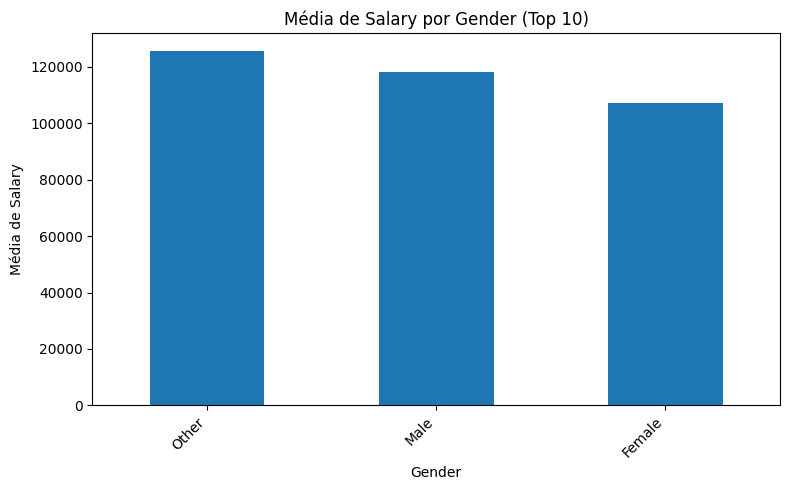

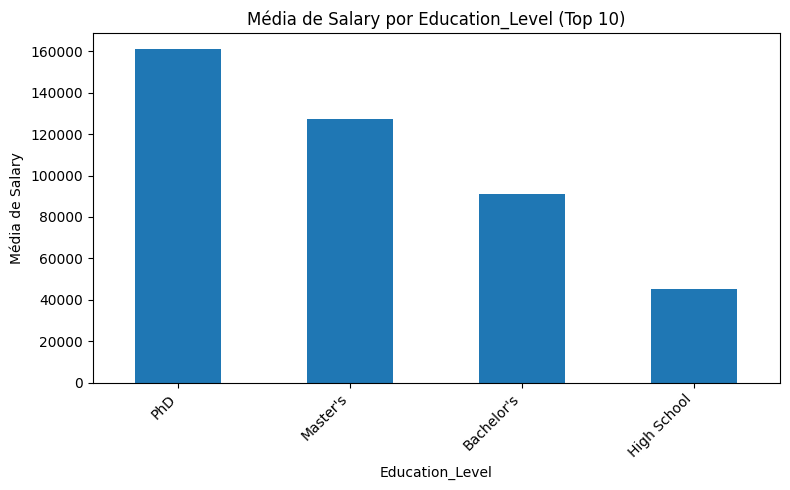

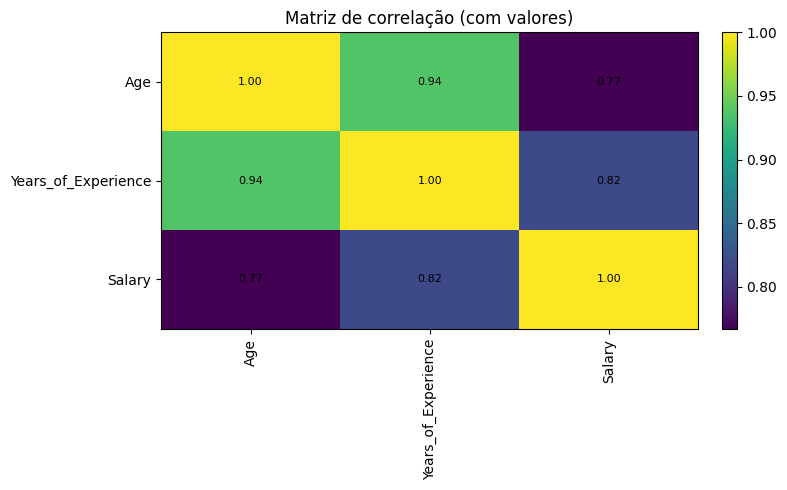

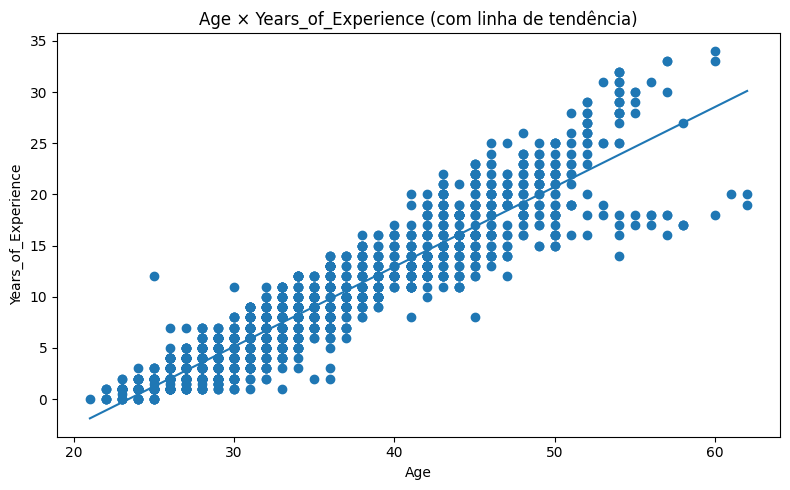

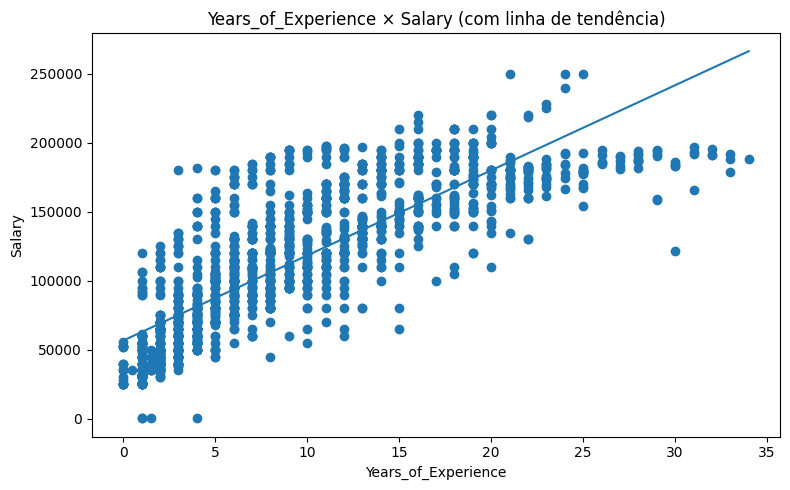

In [ ]:

def find_col_like(patterns, prefer_numeric=True):
    for c in df.columns:
        lc = c.lower()
        if any(p in lc for p in patterns):
            if not prefer_numeric or pd.api.types.is_numeric_dtype(df[c]):
                return c
    return None

def trendline(ax, x, y):
    m, b = np.polyfit(x, y, 1)
    xx = np.linspace(x.min(), x.max(), 100)
    yy = m*xx + b
    ax.plot(xx, yy)

# Histograma + Boxplot
plt.figure(); plt.hist(df[TARGET].dropna(), bins=30); plt.title(f"Distribuição do alvo: {TARGET}"); plt.xlabel(TARGET); plt.ylabel("Frequência"); plt.show()
plt.figure(); plt.boxplot(df[TARGET].dropna(), labels=[TARGET]); plt.title(f"Boxplot do alvo: {TARGET}"); plt.show()

# Barras por categorias (até 2 categóricas)
cat_feats = [c for c in FEATURES if not pd.api.types.is_numeric_dtype(df[c])]
for c in cat_feats[:2]:
    top = df[c].value_counts().head(10).index
    sub = df[df[c].isin(top)]
    means = sub.groupby(c)[TARGET].mean().sort_values(ascending=False)
    plt.figure(); means.plot(kind='bar'); plt.title(f"Média de {TARGET} por {c} (Top 10)"); plt.xlabel(c); plt.ylabel(f"Média de {TARGET}")
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

# Correlação com números
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    fig, ax = plt.subplots()
    im = ax.imshow(corr, aspect='auto'); fig.colorbar(im, fraction=0.046, pad=0.04)
    ax.set_title("Matriz de correlação (com valores)")
    ax.set_xticks(range(len(num_cols))); ax.set_yticks(range(len(num_cols)))
    ax.set_xticklabels(num_cols, rotation=90); ax.set_yticklabels(num_cols)
    for i in range(len(num_cols)):
        for j in range(len(num_cols)):
            ax.text(j, i, f"{corr.iloc[i,j]:.2f}", ha='center', va='center', fontsize=8)
    plt.tight_layout(); plt.show()

# Age × Years_of_Experience com tendência
age_col = find_col_like(['age'])
exp_col = find_col_like(['experience','years','yoe','exp'])
if age_col and exp_col and pd.api.types.is_numeric_dtype(df[age_col]) and pd.api.types.is_numeric_dtype(df[exp_col]):
    fig, ax = plt.subplots()
    ax.scatter(df[age_col], df[exp_col])
    trendline(ax, df[age_col].values, df[exp_col].values)
    ax.set_title(f"{age_col} × {exp_col} (com linha de tendência)")
    ax.set_xlabel(age_col); ax.set_ylabel(exp_col)
    plt.tight_layout(); plt.show()

# (extra) Experience × TARGET com tendência
if exp_col and pd.api.types.is_numeric_dtype(df[exp_col]):
    fig, ax = plt.subplots()
    ax.scatter(df[exp_col], df[TARGET])
    trendline(ax, df[exp_col].values, df[TARGET].values)
    ax.set_title(f"{exp_col} × {TARGET} (com linha de tendência)")
    ax.set_xlabel(exp_col); ax.set_ylabel(TARGET)
    plt.tight_layout(); plt.show()


## 6) Modelagem automática (Regressão) — comparação e escolha
- Os gráficos e métricas mostram que o **Random Forest** foi o modelo mais eficaz, alcançando o maior R² (0,906) e os menores erros (RMSE ≈ 15.489 e MAE ≈ 10.693). Isso significa que ele explica cerca de 91% da variabilidade do salário e apresenta o menor erro médio de previsão em dólares.
- O Gradient Boosting com GridSearch também teve bom desempenho (R² = 0,888), mas não superou a Random Forest, enquanto a Regressão Linear ficou bem abaixo (R² = 0,805) e com erros significativamente mais altos, mostrando dificuldade em capturar relações não lineares entre as variáveis e o salário.
- De forma geral, os gráficos deixam claro que modelos de árvores são mais adequados para esse tipo de dataset, pois conseguem lidar melhor com interações e padrões complexos do que uma abordagem linear simples. **A escolha do melhor modelo foi feita pelo menor RMSE**, e o Random Forest se destacou como o mais confiável para prever salários neste conjunto de dados.

Resultados (ordenado por RMSE):
RandomForest                    R²=0.906  RMSE=15489.086  MAE=10693.645
GradientBoosting(GridSearch)    R²=0.888  RMSE=16957.974  MAE=12475.017
GradientBoosting                R²=0.872  RMSE=18127.304  MAE=13707.027
LinearRegression                R²=0.805  RMSE=22319.701  MAE=16796.544


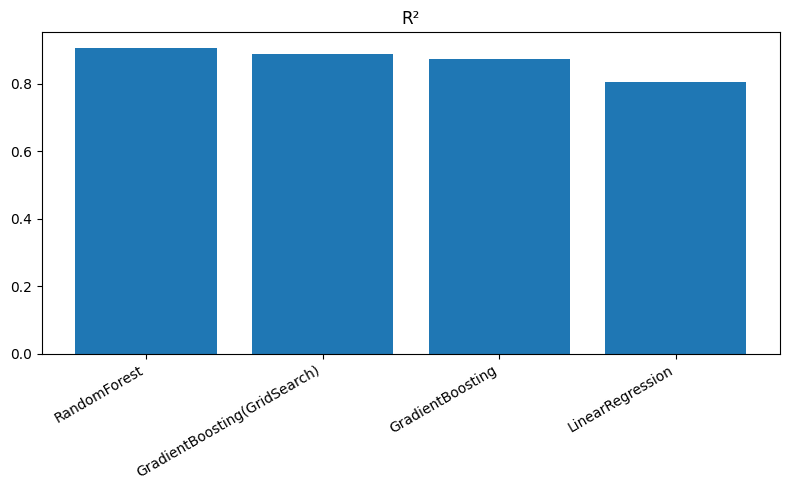

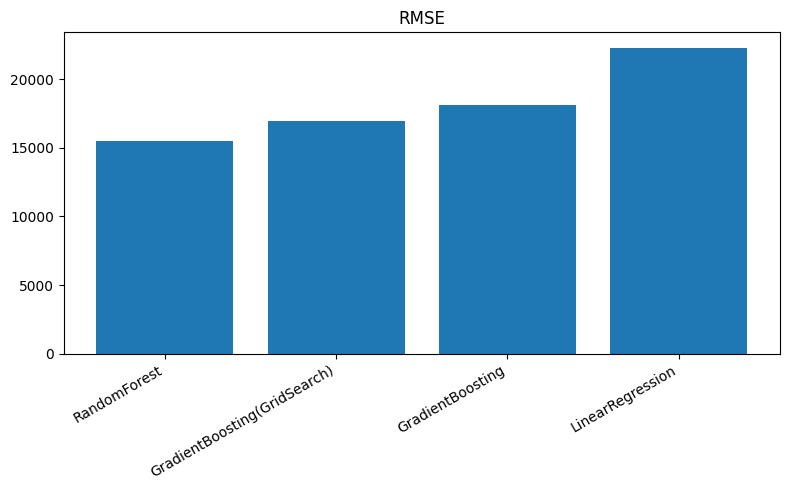

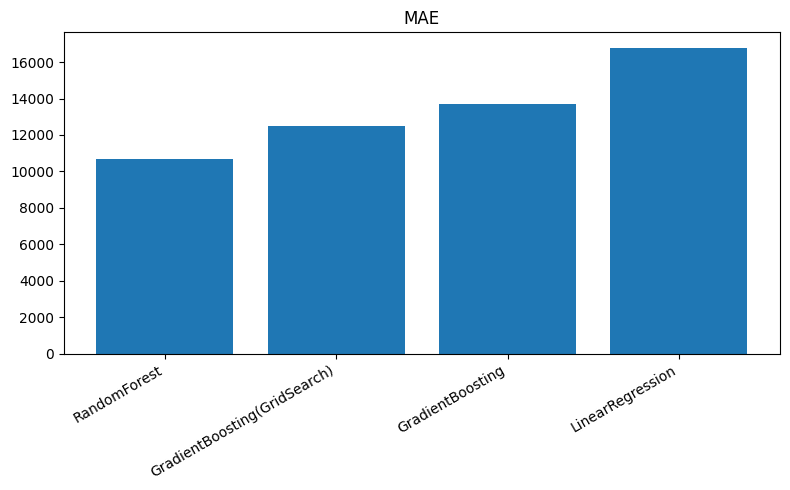

Melhor (RMSE): RandomForest


In [ ]:

data = df.dropna(subset=[TARGET]).copy()
X = data[FEATURES].copy()
y = data[TARGET].astype(float)

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

prep = ColumnTransformer([('num', StandardScaler(), num_cols),
                          ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)])

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=300),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
for name, model in models.items():
    pipe = Pipeline([('prep', prep), ('model', model)])
    pipe.fit(Xtr, ytr)
    p = pipe.predict(Xte)
    r2 = r2_score(yte, p)
    mse = mean_squared_error(yte, p)      # sem 'squared' para compatibilidade
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(yte, p)
    results.append((name, pipe, r2, rmse, mae))

# GridSearch no GB
grid = GridSearchCV(Pipeline([('prep', prep), ('model', GradientBoostingRegressor(random_state=42))]),
                    {'model__n_estimators':[100,200], 'model__learning_rate':[0.05,0.1], 'model__max_depth':[2,3]},
                    scoring='neg_mean_squared_error', cv=3, n_jobs=-1)  # compatível
grid.fit(Xtr, ytr)
p = grid.best_estimator_.predict(Xte)
r2 = r2_score(yte, p); rmse = float(np.sqrt(mean_squared_error(yte, p))); mae = mean_absolute_error(yte, p)
results.append(("GradientBoosting(GridSearch)", grid.best_estimator_, r2, rmse, mae))

results_sorted = sorted(results, key=lambda x: x[3])
print("Resultados (ordenado por RMSE):")
for n, _, r2, rmse, mae in results_sorted:
    print(f"{n:30s}  R²={r2:.3f}  RMSE={rmse:.3f}  MAE={mae:.3f}")

labels = [r[0] for r in results_sorted]
r2_vals = [r[2] for r in results_sorted]
rmse_vals = [r[3] for r in results_sorted]
mae_vals = [r[4] for r in results_sorted]

plt.figure(); plt.bar(labels, r2_vals); plt.title("R²"); plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()
plt.figure(); plt.bar(labels, rmse_vals); plt.title("RMSE"); plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()
plt.figure(); plt.bar(labels, mae_vals); plt.title("MAE"); plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()

BEST_NAME, BEST_PIPE = results_sorted[0][0], results_sorted[0][1]
print("Melhor (RMSE):", BEST_NAME)


## 7) UI de Previsão (sem botão: atualiza ao mover os controles)

In [ ]:

def build_controls(features):
    ctrls = []
    for c in features:
        if pd.api.types.is_numeric_dtype(df[c]):
            lo, hi = float(df[c].quantile(0.05)), float(df[c].quantile(0.95))
            step = (hi-lo)/100 if hi>lo else 1.0
            if pd.api.types.is_float_dtype(df[c]):
                w = widgets.FloatSlider(description=c, min=lo, max=hi if hi>lo else lo+1, step=step, value=float(df[c].median()), continuous_update=True)
            else:
                w = widgets.IntSlider(description=c, min=int(lo), max=int(hi) if hi>0 else int(lo)+1, step=max(1,int(step)), value=int(df[c].median()), continuous_update=True)
        else:
            opts = sorted(df[c].astype(str).unique().tolist())
            w = widgets.Dropdown(description=c, options=opts, value=opts[0] if opts else None)
        ctrls.append(w)
    return ctrls

controls = build_controls(FEATURES)
box = widgets.VBox(controls)
out = widgets.Output()

def update_prediction(change=None):
    data = {c.description:[c.value] for c in controls}
    Xnew = pd.DataFrame(data)
    yhat = BEST_PIPE.predict(Xnew)[0]
    out.clear_output()
    with out:
        print(f"Previsão de salário: {yhat:,.2f}")

for c in controls:
    if hasattr(c, 'observe'):
        c.observe(update_prediction, names='value')

display(box, out)
update_prediction()  # faz a primeira previsão automática


Output()

## 8) Classificação derivada do target — matriz de confusão automática
Esse passo transforma o problema em classificação só para fins de visualização, e a matriz de confusão mostra que o modelo tem boa capacidade de distinguir entre salários baixos, médios e altos, errando apenas em fronteiras próximas entre as faixas.

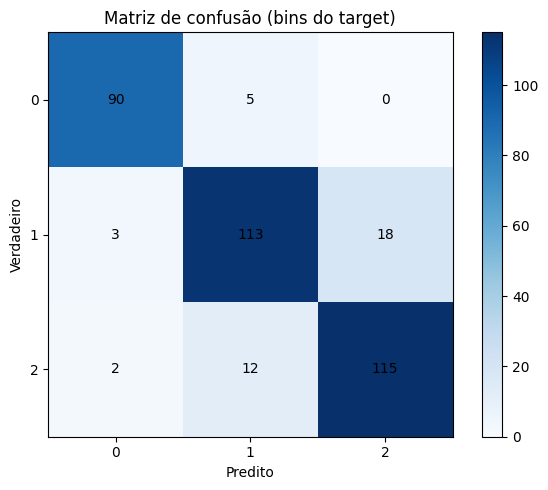

In [ ]:

# Binning do target para fins didáticos (3 faixas por quantis)
y_cont = data[TARGET].astype(float).values
bins = np.quantile(y_cont, np.linspace(0,1,4))  # 3 bins
bins[0] -= 1e-6; bins[-1] += 1e-6
y_cat = np.digitize(y_cont, bins[1:-1])
Xc = data[FEATURES].copy()

num_cols = [c for c in Xc.columns if pd.api.types.is_numeric_dtype(Xc[c])]
cat_cols = [c for c in Xc.columns if c not in num_cols]
prep_c = ColumnTransformer([('num', StandardScaler(), num_cols), ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)])

Xtr, Xte, ytr, yte = train_test_split(Xc, y_cat, test_size=0.2, random_state=42)
clf = Pipeline([('prep', prep_c), ('model', RandomForestClassifier(random_state=42, n_estimators=300))])
clf.fit(Xtr, ytr)
yp = clf.predict(Xte)

cm = confusion_matrix(yte, yp, labels=[0,1,2])
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
ax.set_title("Matriz de confusão (bins do target)"); ax.set_xlabel("Predito"); ax.set_ylabel("Verdadeiro")
ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
for i in range(3):
    for j in range(3):
        ax.text(j, i, str(cm[i,j]), ha='center', va='center')
fig.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()


## 9) Conclusões
A análise exploratória mostrou que o salário apresenta grande variação, com mediana em torno de 110 mil e presença de outliers que elevam a dispersão. Fatores como nível educacional e anos de experiência se destacaram como os mais influentes, reforçados pela forte correlação entre idade, experiência e remuneração. Esse diagnóstico inicial confirmou a viabilidade de aplicar regressão supervisionada para prever salários com base nas variáveis disponíveis.

Na etapa de modelagem, foram testados quatro modelos de regressão, e o Random Forest se destacou como o mais eficiente, alcançando R² de 0,906 e os menores erros (RMSE ≈ 15.489 e MAE ≈ 10.693). Isso indica que o modelo consegue explicar cerca de 91% da variabilidade do salário, oferecendo previsões robustas e confiáveis. A interface interativa com ipywidgets permitiu explorar cenários em tempo real, e a classificação derivada (matriz de confusão) demonstrou que o modelo também separa bem faixas de remuneração. Assim, o notebook cumpre seu objetivo de construir um MVP funcional para previsão de salários, unindo análise, modelagem e apresentação didática dos resultados.